# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

## Preprocess input data

Join train and test

In [4]:
data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)

data_train.loc[:, 'is_train'] = 1
data_test.loc[:, 'is_train'] = 0

data = pd.concat([data_train, data_test], axis=0)

In [5]:
data['participants_sex'] = data['participants_sex'].map({'F': -1.0, 'M': +1.0}) 
accepted_anatomy = data['anatomy_select'] < 2

In [6]:
data.shape

(1150, 222)

Remove poor QA data

In [7]:
data1 = data[accepted_anatomy].copy()
data1.shape

(948, 222)

In [8]:
import re 

left_cols = sorted([col for col in data1.columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

left_cols.remove('anatomy_Left-WM-hypointensities')
left_cols.remove('anatomy_Left-non-WM-hypointensities')

right_cols = []
for c in left_cols:
    if "lh" in c:
        c = c.replace("lh", "rh")
    elif "Left" in c:
        c = c.replace("Left", "Right")
    right_cols.append(c)

anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]

In [9]:
to_remove_anatomy_features = [
    'anatomy_Left-WM-hypointensities',
    'anatomy_Left-non-WM-hypointensities',
    'anatomy_Right-WM-hypointensities',
    'anatomy_Right-non-WM-hypointensities',
    'anatomy_5th-Ventricle', 
    'anatomy_non-WM-hypointensities',
    # Correlated with others
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_SupraTentorialVolNotVentVox',
#     'anatomy_SubCortGrayVol',
#     'anatomy_TotalGrayVol',
    # Remove correlated L <-> R
    'anatomy_Right-Caudate',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_Right-Putamen',
    'anatomy_Right-VentralDC',
    'anatomy_rhCerebralWhiteMatterVol',
    'anatomy_rhCortexVol',
    'anatomy_rhSurfaceHoles',
    'anatomy_rh_MeanThickness_thickness',
    'anatomy_rh_WhiteSurfArea_area',
    'anatomy_rh_superiorparietal_thickness',
]

compute_diff_and_remove_first_anatomy_features = [
    ('anatomy_SubCortGrayVol', 'anatomy_BrainSegVol'),    
    ('anatomy_TotalGrayVol', 'anatomy_CortexVol'),    
]

In [10]:
anatomy_cols = [col for col in data1.columns if col.startswith('anatomy')]

anatomy_cols.remove('anatomy_select')

for c in to_remove_anatomy_features:
    anatomy_cols.remove(c)

participant_cols = [col for col in data1.columns if col.startswith('participant')]
participant_cols.remove('participants_site')

In [11]:
len(anatomy_cols)

189

In [12]:
anatomy_diff_cols = []
to_remove_anatomy_diff_cols = []


for c1, c2 in anatomy_LR_diff_cols:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))

    
for c1, c2 in compute_diff_and_remove_first_anatomy_features:
    data1.loc[:, "({} - {})".format(c1, c2)] = data1[c1] - data1[c2]
    anatomy_diff_cols.append("({} - {})".format(c1, c2))
    to_remove_anatomy_diff_cols.append(c1)

for c in to_remove_anatomy_diff_cols:
    anatomy_cols.remove(c)    

In [13]:
len(anatomy_diff_cols)

89

In [14]:
data1.shape

(948, 311)

In [15]:
inverted_cols = []

for c in anatomy_cols + anatomy_diff_cols + ["participants_age", ]:
    data1.loc[:, "1/({})".format(c)] = 1.0 / (data1[c] + 1e-10)
    inverted_cols.append("1/({})".format(c))

In [16]:
data1.head()

,participants_site,participants_sex,participants_age,anatomy_lh_bankssts_area,anatomy_lh_caudalanteriorcingulate_area,anatomy_lh_caudalmiddlefrontal_area,anatomy_lh_cuneus_area,anatomy_lh_entorhinal_area,anatomy_lh_fusiform_area,anatomy_lh_inferiorparietal_area,...,1/((anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)),1/((anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area)),1/((anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness)),1/((anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)),1/((anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness)),1/((anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area)),1/((anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)),1/((anatomy_SubCortGrayVol - anatomy_BrainSegVol)),1/((anatomy_TotalGrayVol - anatomy_CortexVol)),1/(participants_age)
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,5,-1.0,9.301370,977.0,427.0,1884.0,1449.0,463.0,2790.0,4091.0,...,166.666664,-0.011494,-13.333333,-0.028571,10.989011,0.010000,5.128205,-9.802163e-07,0.000007,0.107511
5174041730092253771,19,1.0,29.000000,1279.0,730.0,2419.0,1611.0,467.0,3562.0,5380.0,...,-35.714286,0.001361,-25.000000,-0.014085,4.201681,0.006711,5.882353,-7.816976e-07,0.000005,0.034483
10219322676643534800,19,-1.0,45.000000,926.0,446.0,1897.0,2135.0,570.0,3064.0,4834.0,...,-83.333334,0.001842,18.867924,-0.037037,-29.411765,0.008000,-33.333333,-9.670422e-07,0.000006,0.022222
10645466564919190227,5,-1.0,9.216438,983.0,588.0,2479.0,1312.0,525.0,3766.0,5091.0,...,-18.181818,0.001458,-3.571429,0.142857,2.680965,0.008475,-13.513514,-8.719460e-07,0.000006,0.108502
14512541342641936232,28,1.0,15.050000,1488.0,593.0,2309.0,1829.0,726.0,3720.0,5432.0,...,-9.345794,0.004274,27.027027,0.142857,8.264463,0.005319,-3.448276,-8.261698e-07,0.000005,0.066445


In [17]:
data1.shape

(948, 588)

Polynomial 2nd degree



In [18]:
train_columns1 = anatomy_cols + anatomy_diff_cols + ['participants_age', ]
train_columns2 = inverted_cols
train_columns = train_columns1 + train_columns2
len(train_columns1), len(train_columns2)

(277, 277)

In [19]:
data_ = data1[train_columns].values
data_.shape

(948, 554)

In [20]:
pairs_columns = []

n1 = len(train_columns1) * (len(train_columns1) - 1) // 2
n2 = (len(train_columns1) - 1) * len(train_columns2)

pairs_data = np.zeros((len(data_), n1 + n2))

c = 0
for i, f1 in enumerate(train_columns1):
    for j, f2 in enumerate(train_columns1):
        if i < j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1
            
    for j, f2 in enumerate(train_columns2):
        if i != j:
            pairs_columns.append("{} x {}".format(f1, f2))
            pairs_data[:, c] = data_[:, i] * data_[:, j]
            c += 1            

In [21]:
pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=data1.index)

In [22]:
pairs_columns = pairs_df.columns.values.tolist()
pairs_df.shape

(948, 114678)

In [23]:
data2 = pd.concat([data1, pairs_df], axis=1)

In [24]:
data2.shape

(948, 115266)

In [25]:
train_columns = anatomy_cols + anatomy_diff_cols + participant_cols + inverted_cols + pairs_columns
len(train_columns)

115233

Basic feature selection

In [26]:
corr12_inv = [
    data2[c].corr(data2['target']) for c in train_columns
]
corr12_inv_ = pd.Series(corr12_inv, index=train_columns)

In [27]:
corr12_inv_approx = corr12_inv_.apply(lambda x: round(x, 5))

filtered_corr12_inv_ = corr12_inv_approx[~corr12_inv_approx.duplicated()]

In [28]:
filtered_corr12_inv_.shape, corr12_inv_.shape

((15276,), (115233,))

In [39]:
filtered_corr12_inv_2 = filtered_corr12_inv_[filtered_corr12_inv_.abs() > 0.035]

In [41]:
corr_selected_columns = filtered_corr12_inv_2.index.values.tolist()
corr_selected_columns[-10:], len(corr_selected_columns)

(['(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)',
  '(anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area) x (anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness)',
  '(anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness) x (anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area)',
  '(anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness) x (anatomy_SubCortGrayVol - anatomy_BrainSegVol)',
  '(anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness) x (anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area)',
  '(anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness) x (anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness)',
  '(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy

Run CV GBM to select best features

In [42]:
import lightgbm as lgb

In [43]:
gbm_data = lgb.Dataset(data2[corr_selected_columns], label=data2['target'])

In [44]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'num_leaves': 30,
    'max_depth': 20,
    'learning_rate': 0.01,
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
}

num_boost_round = 250

In [45]:
cv_results = lgb.cv(params, gbm_data, num_boost_round=num_boost_round, nfold=5,
                    metrics='auc',              
                    early_stopping_rounds=10, verbose_eval=1)

[1]	cv_agg's auc: 0.581937 + 0.029494
[2]	cv_agg's auc: 0.588638 + 0.0244455
[3]	cv_agg's auc: 0.586226 + 0.0319699
[4]	cv_agg's auc: 0.589463 + 0.026875
[5]	cv_agg's auc: 0.588356 + 0.0217409
[6]	cv_agg's auc: 0.588884 + 0.0206707
[7]	cv_agg's auc: 0.590594 + 0.0307596
[8]	cv_agg's auc: 0.589031 + 0.0335051
[9]	cv_agg's auc: 0.589474 + 0.0301315
[10]	cv_agg's auc: 0.588101 + 0.030642
[11]	cv_agg's auc: 0.590368 + 0.0310007
[12]	cv_agg's auc: 0.595719 + 0.0300588
[13]	cv_agg's auc: 0.593882 + 0.0291656
[14]	cv_agg's auc: 0.596373 + 0.0317312
[15]	cv_agg's auc: 0.597343 + 0.0341261
[16]	cv_agg's auc: 0.600102 + 0.0341945
[17]	cv_agg's auc: 0.599817 + 0.0340841
[18]	cv_agg's auc: 0.602055 + 0.0367959
[19]	cv_agg's auc: 0.602586 + 0.0368942
[20]	cv_agg's auc: 0.603983 + 0.0376542
[21]	cv_agg's auc: 0.602285 + 0.0386714
[22]	cv_agg's auc: 0.604789 + 0.0393982
[23]	cv_agg's auc: 0.605515 + 0.0395945
[24]	cv_agg's auc: 0.605445 + 0.0390302
[25]	cv_agg's auc: 0.61073 + 0.0409279
[26]	cv_agg's

In [46]:
lgb.plot_importance(gbm, figsize=(15, 15))

NameError: name 'gbm' is not defined

In [88]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [89]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

Check `corr_selected_columns`

In [90]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.628 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.593 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished


### Feature importance of extracted features

In [58]:
from sklearn.feature_selection import SelectFromModel

pipe = make_pipeline(StandardScaler(), LogisticRegression(C=100, n_jobs=1, random_state=seed))
log_reg = pipe.named_steps['logisticregression']
feature_selection = SelectFromModel(log_reg, prefit=True, threshold="2.5*mean")

In [59]:
pipe.fit(data2[train_columns], data2['target'])

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=90, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [60]:
transformed_data = feature_selection.transform(data2[train_columns])

In [61]:
transformed_data.shape

(948, 8689)

In [63]:
np_train_columns = np.array(train_columns)

In [64]:
selected_columns = feature_selection.transform(np_train_columns[None, :])[0].tolist()

In [40]:
# log_reg = pipe.named_steps['logisticregression']

# coef = log_reg.coef_.ravel()
# positive_coefficients_2 = np.argsort(coef)
# negative_coefficients_2 = np.argsort(coef)

# coef.min(), coef.max(), np.abs(coef).min()

# sns.distplot(coef, kde=False)

# n_top_features = 400

# positive_coefficients = positive_coefficients_2[-n_top_features:]
# negative_coefficients = negative_coefficients_2[:n_top_features]
# interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

# top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()



## Train a linear model 

In [91]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

n_jobs=1
seed = 42


class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), 
                                 LogisticRegression(random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [92]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

Check `corr_selected_columns`

In [70]:
import numpy as np

results = evaluation(data2[selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.671 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.630 +- 0.013


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.2s finished


A reference with feature ^ 2
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.637 +- 0.014 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.604 +- 0.014
```

In [95]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [96]:
import numpy as np

results = evaluation(data2[corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.832 +- 0.124
Validation score ROC-AUC: 0.624 +- 0.014 

Training score accuracy: 0.789 +- 0.144
Validation score accuracy: 0.594 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.2s finished


In [57]:
import numpy as np

results = evaluation(data2[selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.697 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.654 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.0min finished


In [56]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Feature importance of Corr selected features

In [131]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [132]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

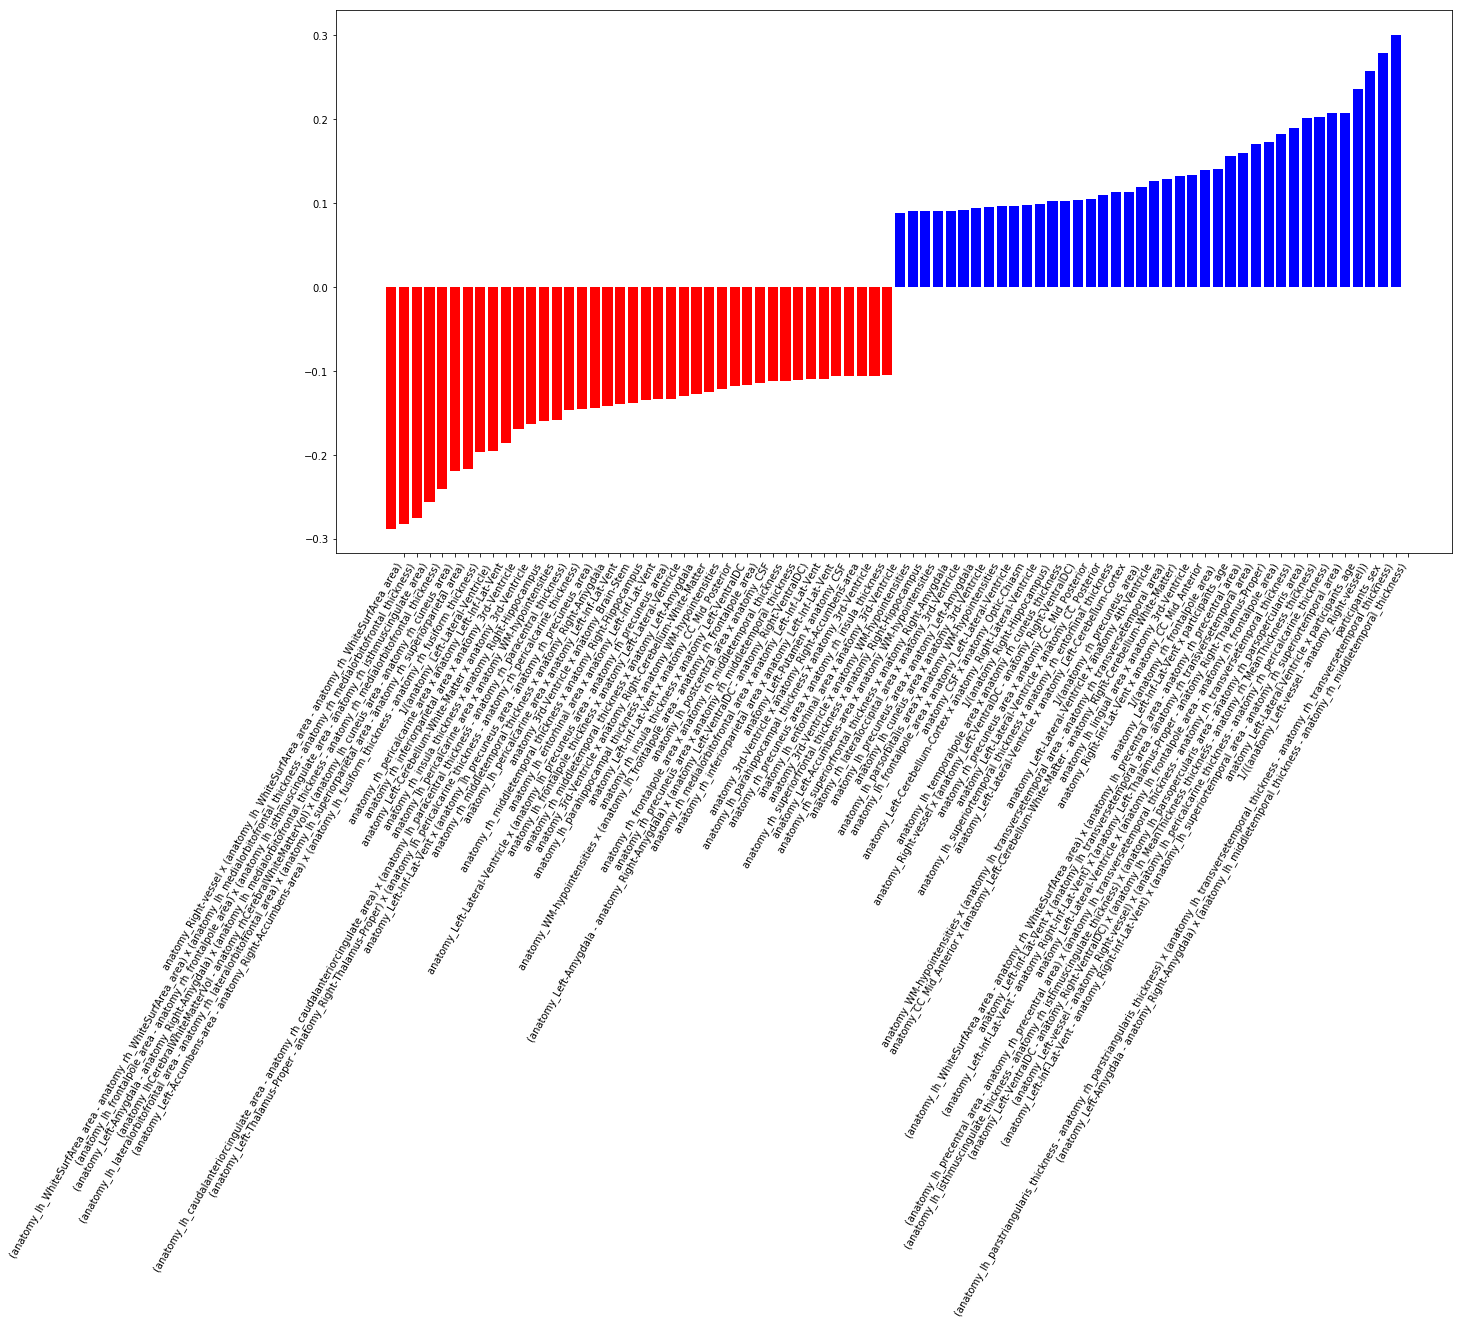

In [133]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [134]:
coef2 = log_reg2.coef_.ravel()
positive_coefficients_2 = np.argsort(coef2)
negative_coefficients_2 = np.argsort(coef2)

In [135]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.28828294730874016, 0.3009420078520525, 1.9741951664670143e-06)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


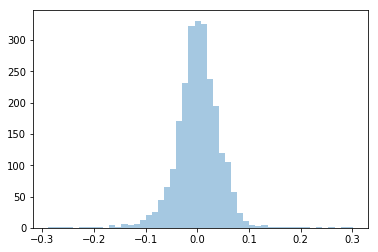

In [136]:
sns.distplot(coef2, kde=False)

In [149]:
n_top_features = 400

positive_coefficients = positive_coefficients_2[-n_top_features:]
negative_coefficients = negative_coefficients_2[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [150]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [151]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.988 +- 0.015
Validation score ROC-AUC: 0.746 +- 0.017 

Training score accuracy: 0.950 +- 0.037
Validation score accuracy: 0.685 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


150 (0.088 Corr threshold)
```
Training score ROC-AUC: 0.970 +- 0.027
Validation score ROC-AUC: 0.765 +- 0.019 

Training score accuracy: 0.918 +- 0.051
Validation score accuracy: 0.700 +- 0.017
```

175 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.986 +- 0.009
Validation score ROC-AUC: 0.812 +- 0.014 

Training score accuracy: 0.946 +- 0.028
Validation score accuracy: 0.732 +- 0.012
```

160 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.985 +- 0.011
Validation score ROC-AUC: 0.811 +- 0.009 

Training score accuracy: 0.944 +- 0.030
Validation score accuracy: 0.733 +- 0.011
```

140 (0.04 Corr threshold)
```
Training score ROC-AUC: 0.982 +- 0.012
Validation score ROC-AUC: 0.811 +- 0.012 

Training score accuracy: 0.937 +- 0.029
Validation score accuracy: 0.732 +- 0.015
```


140 (0.05 Corr threshold)
```
Training score ROC-AUC: 0.979 +- 0.018
Validation score ROC-AUC: 0.797 +- 0.006 

Training score accuracy: 0.933 +- 0.038
Validation score accuracy: 0.717 +- 0.010
```

SelectFromModel

In [41]:
print("[", end="")
for f in selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [50]:
print("[", end="")
for f in top_corr_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["(anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area) x (anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness)", "(anatomy_Left-Hippocampus - anatomy_Right-Hippocampus) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness) x (anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-vessel - anatomy_Right-vessel) x (anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness)", "(anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area) x (anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area) x (anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness)", "(anatomy_Left-Pallidum - anatomy_Right-Pallidum) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cor